# Prepare

## Install Packages & Download Data 

In [1]:
%%bash
pip install --upgrade category_encoders scikit-learn
cp /content/drive/MyDrive/pyism/{utils,datetime_encoder}.py /content

## Load in Data  

In [2]:
import numpy as np
import pandas as pd
import os
import category_encoders as ce
from datetime_encoder import DatetimeEnricher
from sklearn.ensemble import RandomForestRegressor

BASE_DIR = os.getcwd()
PROJECT_DIR = os.path.join(BASE_DIR, 'drive', 'MyDrive', 'Colab Notebooks', 'projects', 'bulldozers')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train = pd.read_feather(os.path.join(PROJECT_DIR, 'data', 'preproc_train.feather')).fillna(value=np.nan)
valid = pd.read_feather(os.path.join(PROJECT_DIR, 'data', 'preproc_valid.feather')).fillna(value=np.nan)

train.shape, valid.shape

((401125, 54), (11573, 54))

In [4]:
to_fill = train.groupby('Enclosure', dropna=False).mean()['YearMade'].to_dict()
train.replace(1000, np.nan, inplace=True)
train.YearMade.fillna(train.Enclosure.map(to_fill), inplace=True)
valid.replace(1000, np.nan, inplace=True)
valid.YearMade.fillna(valid.Enclosure.map(to_fill), inplace=True)

In [5]:
train.ModelID = train.ModelID.map(pd.cut(np.log1p(train.groupby('ModelID').mean().SalePrice), bins=100).cat.codes.to_dict())
valid.ModelID = valid.ModelID.map(pd.cut(np.log1p(valid.groupby('ModelID').mean().SalePrice), bins=100).cat.codes.to_dict())

In [6]:
xtrn = train.drop(columns='SalePrice')
ytrn = np.log1p(train.SalePrice)
xval = valid.drop(columns='SalePrice')
yval = np.log1p(valid.SalePrice)

In [7]:
# xtrn['Condition'] = pd.cut((xtrn.saledate.dt.year - xtrn.YearMade).abs(), bins=4, labels=['Very New', 'New', 'Old', 'Very Old']).astype('object')
# xval['Condition'] = pd.cut((xval.saledate.dt.year - xval.YearMade).abs(), bins=4, labels=['Very New', 'New', 'Old', 'Very Old']).astype('object')

In [8]:
# xtrn.ModelID = xtrn.ModelID.astype('category')
# xval.ModelID = xval.ModelID.astype('category')

## Helper functions 

In [9]:
def clean_YearMade(X):
    assert 'YearMade' in X.columns
    # X['YearMade_na'] = X.YearMade==1000
    X.YearMade.replace(1000, X.YearMade.mean(), inplace=True)
    return X

In [10]:
def add_columns(X, cols, postfix):
    cols = np.array(cols, dtype="object")
    freq = X[cols]
    freq.columns = cols + postfix
    return X.merge(freq, left_index=True, right_index=True), freq.columns


# Main Event 

## Columns for Each Encoder 

In [11]:
cat_cols = xtrn.select_dtypes(include=["object","category"]).columns
num_cols = xtrn.select_dtypes(exclude=["object","category"]).columns

ordinal_cols = ['UsageBand','ProductSize','Drive_System']
                # , 'Condition', 'Grouser_Type', 'Enclosure_Type','Enclosure', 'Blade_Width','Coupler',]
cat_cols = np.setdiff1d(cat_cols, ordinal_cols) 

onehot_cols = cat_cols[xtrn[cat_cols].nunique() <= 4]

id_cols = ['ModelID']

ec_cols = np.setdiff1d(cat_cols, onehot_cols)

In [12]:
# xtrn, freq_cols = add_columns(clean_YearMade(xtrn), id_cols, "_freq")
# xval, _ = add_columns(clean_YearMade(xval), id_cols, "_freq")

In [13]:
ordinal_mappings = [
    dict(col='UsageBand', mapping=dict(High=2, Medium=1, Low=0)),
    dict(col='ProductSize', mapping={'Compact':5, 'Large':4, 'Large / Medium':3, 'Medium':2, 'Mini':1, 'Small':0}),
    dict(col='Drive_System', mapping={'All Wheel Drive':3, 'Four Wheel Drive':2, 'Two Wheel Drive':1, 'No':0}),
    # dict(col='Condition', mapping={'Very New':3, 'New':2, 'Old':1, 'Very Old':0})
    # dict(col='Enclosure_Type', mapping={'High Profile':2, 'Low Profile':1, 'None or Unspecified ':0}),
    # dict(col='Enclosure', mapping={'EROPS w AC':4, 'EROPS AC':4, 'EROPS':3, 'OROPS':2, 'NO ROPS':1, 'None or Unspecified':0}),
    # dict(col='Blade_Width', mapping={'None or Unspecified':0, "<12'":1, "12'":2, "13'":3, "14'":4, "16'":5}),
    # dict(col='Coupler', mapping={'Hydraulic':2, 'Manual':1, 'None or Unspecified':0}),
    # dict(col='Grouser_Type', mapping={'Double':1, 'Single':0, 'Triple':2}),
]

date_attrs = ['day','year','month','quarter','week',
              'dayofweek', 'dayofyear','days_in_month', 'weekofyear',
              'is_month_end','is_month_start'] 


## Initialize Encoders 

In [14]:
oh = ce.OneHotEncoder(cols=onehot_cols, drop_invariant=True,
                      use_cat_names=True, handle_missing='return_nan', )

od = ce.OrdinalEncoder(cols=ordinal_cols, mapping=ordinal_mappings)
                          
# id = ce.CountEncoder(cols=freq_cols, min_group_size=.01, normalize=True, combine_min_nan_groups=True)

js = ce.JamesSteinEncoder(cols=ec_cols)

me = ce.MEstimateEncoder(cols=ec_cols, m=500)

te = ce.TargetEncoder(cols=ec_cols, min_samples_leaf=100, smoothing=5)

de = DatetimeEnricher(date_col='saledate', date_attrs=date_attrs)

## Build Pipeline 

In [15]:
steps = [
    ('oridnal', od),
    ('onehot', oh),
    # ('count', id),
    ('target', js),
    ('datetime', de),
]

In [16]:
from sklearn.pipeline import Pipeline 
process_pipe = Pipeline(steps=steps)

In [17]:
%%time
xtrn = process_pipe.fit_transform(xtrn, ytrn)
xval = process_pipe.transform(xval)

/usr/local/lib/python3.7/dist-packages/category_encoders/one_hot.py:270: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(col, 1, inplace=True)
/content/datetime_encoder.py:23: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  x['sale_'+attr] = getattr(x[self.date_col].dt, attr)


CPU times: user 25 s, sys: 3.59 s, total: 28.6 s
Wall time: 28.7 s


In [18]:
xtrn.shape, xval.shape

((401125, 99), (11573, 99))

## Handle NA Values 

In [19]:
from utils import impute
# xtrn, nas = impute(xtrn)
# xval, _ = impute(xval, in_nas=nas)
# xtrn['MachineHoursCurrentMeter_na'] = xtrn['MachineHoursCurrentMeter'].isna()
# xval['MachineHoursCurrentMeter_na'] = xval['MachineHoursCurrentMeter'].isna()

In [20]:
xtrn.fillna(0, inplace=True)
xval.fillna(0, inplace=True)


In [21]:
# different numbers of columns
xtrn, xval = xtrn.align(xval, 'inner', axis=1)
xtrn.shape, xval.shape

((401125, 99), (11573, 99))

## Experiment w/ Random Forest 

In [22]:
# yh - yhat: predicted values
def rmse(y, yh):
    return np.sqrt(np.mean((y - yh)**2))

In [23]:
default = {'max_features': 0.5, 'max_samples': 0.5,
           'min_samples_leaf': 3, 'min_samples_split': 5,
           'n_jobs': -1}
random_forest = RandomForestRegressor(100, **default)

In [24]:
model = random_forest
model.fit(xtrn.values, ytrn.values)

RandomForestRegressor(max_features=0.5, max_samples=0.5, min_samples_leaf=3,
                      min_samples_split=5, n_jobs=-1)

In [25]:
# js: .2468
# me: .2504
# te: .2483
rmse(yval, model.predict(xval.values))

0.22524089789775012

In [30]:
from utils import feature_importances
feature_importances(model, xtrn.columns, threshold=.99)

,importance,rank,norm_cummulative
features,,,
ModelID,0.581514,1,0.581514
fiBaseModel,0.145175,2,0.726689
YearMade,0.051609,3,0.778298
sale_year,0.050340,4,0.828638
MachineHoursCurrentMeter,0.024496,5,0.853134
Enclosure_EROPS w AC,0.022375,6,0.875509
ProductGroupDesc,0.013139,7,0.888649
Lb Operating Capacity,0.010889,8,0.899538
fiSecondaryDesc,0.008904,9,0.908442


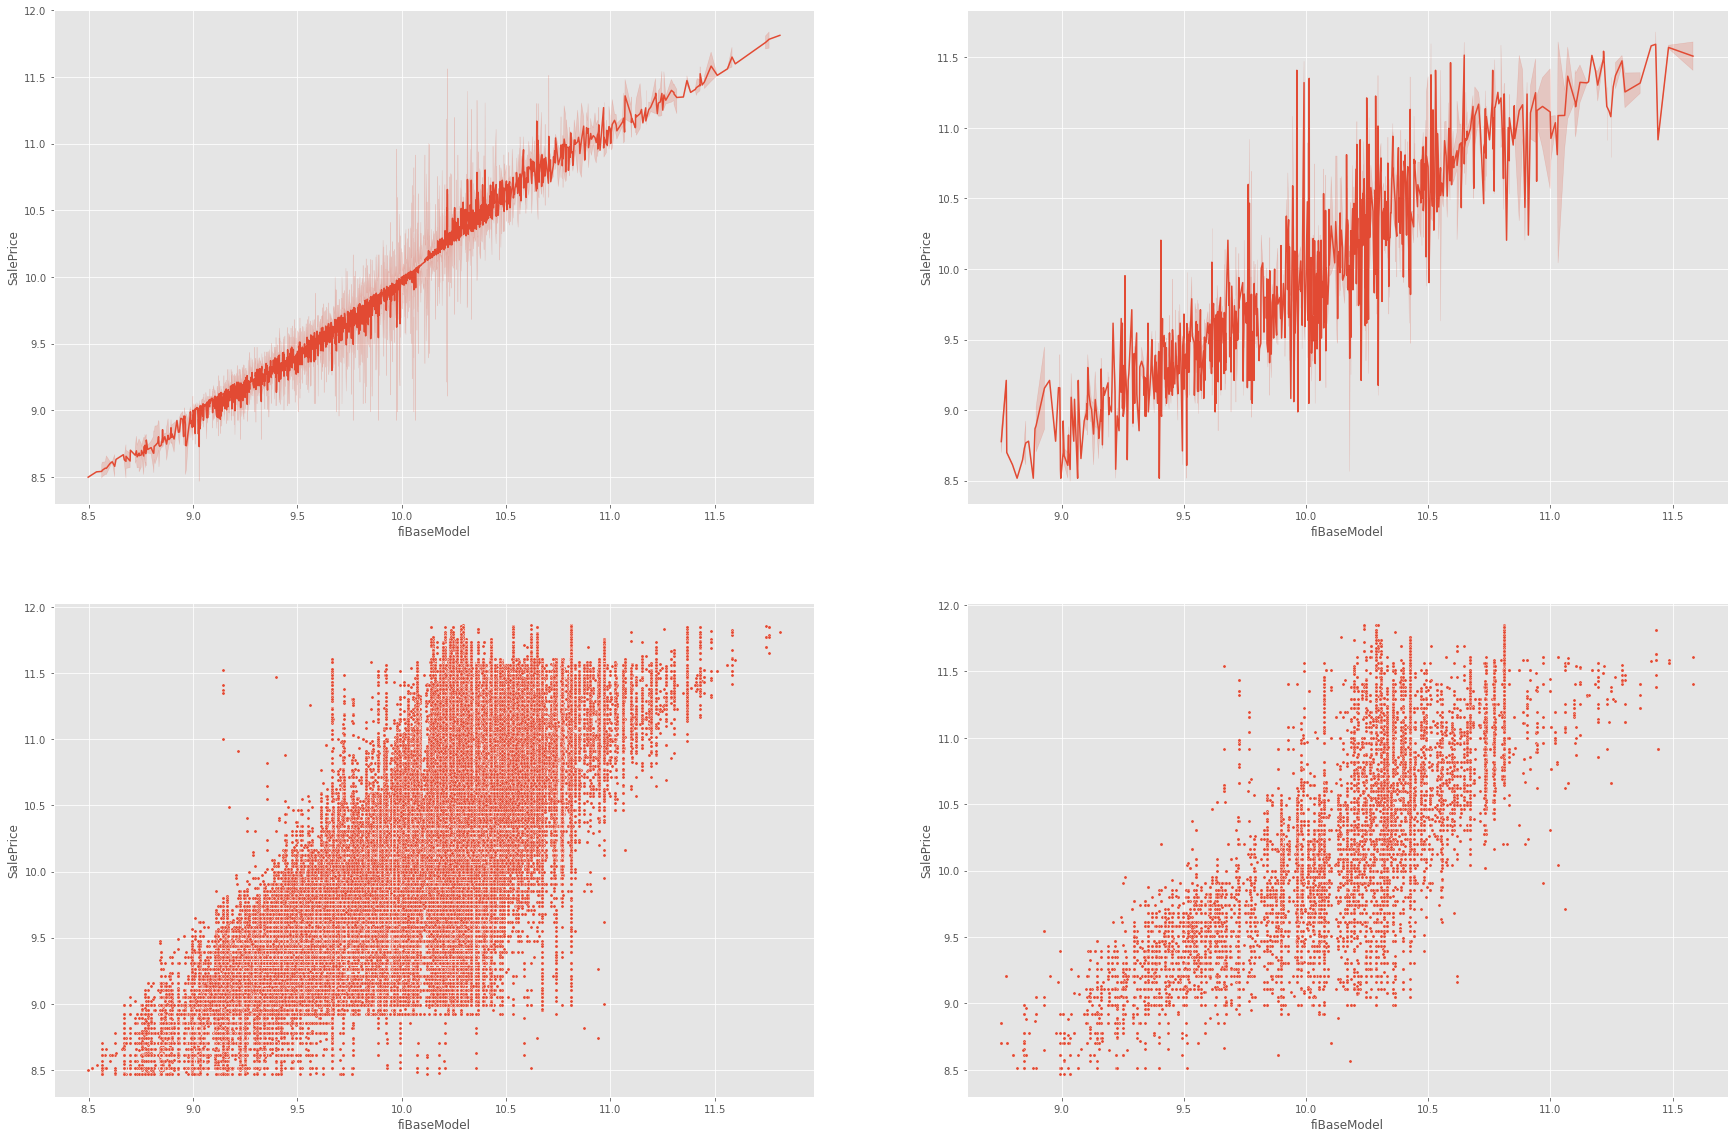

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')
variable = 'fiBaseModel'
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30,20))
sns.lineplot(data=xtrn, x=variable, y=ytrn, ax=axes[0][0]) 
sns.lineplot(data=xval, x=variable, y=yval, ax=axes[0][1])
sns.scatterplot(data=xtrn, x=variable, y=ytrn, s=10, ax=axes[1][0]) 
sns.scatterplot(data=xval, x=variable, y=yval, s=10, ax=axes[1][1])

In [27]:
#@title
xtrn.to_feather("xtrn.feather")
xval.to_feather("xval.feather")
ytrn.to_frame().to_feather('ytrn.feather')
yval.to_frame().to_feather('yval.feather')

In [28]:
#@title
!mv /content/*feather /content/drive/MyDrive/Colab\ Notebooks/projects/bulldozers/data/